# Web Voyager

[WebVoyager](https://arxiv.org/abs/2401.13919) by He, et. al., is a vision-enabled web-browsing agent capable of controlling the mouse and keyboard.

It works by viewing annotated browser screenshots for each turn, then choosing the next step to take. The agent architecture is a basic reasoning and action (ReAct) loop.
The unique aspects of this agent are:
- It's usage of [Set-of-Marks](https://som-gpt4v.github.io/)-like image annotations to serve as UI affordances for the agent
- It's application in the browser by using tools to control both the mouse and keyboard

The overall design looks like the following:

<img src="./img/web-voyager.excalidraw.jpg" src="../img/web-voyager.excalidraw.jpg" >

## Setup

First, let's install our required packages:

In [ ]:
%%capture --no-stderr
%pip install -U --quiet langgraph langsmith langchain_openai cohere

In [ ]:
import cohere
co = cohere.ClientV2("key")


<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>.
    </p>
</div>

#### Install Agent requirements

The only additional requirement we have is the [playwright](https://playwright.dev/) browser. Uncomment and install below:

In [ ]:
%pip install --upgrade --quiet  playwright > /dev/null
!playwright install

164.9 MiB [] 0% 0.0s164.9 MiB [] 0% 12.1s164.9 MiB [] 0% 4.9s164.9 MiB [] 1% 3.8s164.9 MiB [] 1% 3.5s164.9 MiB [] 2% 3.2s164.9 MiB [] 2% 3.1s164.9 MiB [] 3% 2.9s164.9 MiB [] 4% 2.8s164.9 MiB [] 5% 2.6s164.9 MiB [] 6% 2.5s164.9 MiB [] 6% 2.9s164.9 MiB [] 7% 3.0s164.9 MiB [] 7% 2.9s164.9 MiB [] 8% 2.8s164.9 MiB [] 9% 2.7s164.9 MiB [] 9% 2.8s164.9 MiB [] 9% 2.9s164.9 MiB [] 10% 2.9s164.9 MiB [] 11% 2.8s164.9 MiB [] 11% 2.7s164.9 MiB [] 12% 2.6s164.9 MiB [] 13% 2.6s164.9 MiB [] 14% 2.6s164.9 MiB [] 14% 2.5s164.9 MiB [] 15% 2.5s164.9 MiB [] 16% 2.4s164.9 MiB [] 17% 2.3s164.9 MiB [] 18% 2.3s164.9 MiB [] 19% 2.2s164.9 MiB [] 20% 2.1s164.9 MiB [] 21% 2.1s164.9 MiB [] 22% 2.1s164.9 MiB [] 23% 2.0s164.9 MiB [] 24% 2.1s164.9 MiB [] 25% 2.0s164.9 MiB [] 26% 2.0s164.9 MiB [] 27% 1.9s164.9 MiB [] 27% 2.0s164.9 MiB [] 27% 2.1s164.9 MiB [] 28% 2.0s164.9 MiB [] 29% 1.9s164.9 MiB [] 30% 1.9s164.9 MiB [] 31% 1.8s164.9 MiB [] 32% 1.8s164.9 MiB [] 33% 1.8s164.9 MiB [] 34% 1.7s164.9 MiB [] 35% 1.7s164.9 MiB

In [ ]:
import nest_asyncio

# This is just required for running async playwright in a Jupyter notebook
nest_asyncio.apply()

## Define graph

### Define graph state

The state provides the inputs to each node in the graph.

In our case, the agent will track the webpage object (within the browser), annotated images + bounding boxes, the user's initial request, and the messages containing the agent scratchpad, system prompt, and other information.


In [ ]:
from typing import List, Optional
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage, SystemMessage
from playwright.async_api import Page


class BBox(TypedDict):
    x: float
    y: float
    text: str
    type: str
    ariaLabel: str


class Prediction(TypedDict):
    action: str
    args: Optional[List[str]]


# This represents the state of the agent
# as it proceeds through execution
class AgentState(TypedDict):
    page: Page  # The Playwright web page lets us interact with the web environment
    input: str  # User request
    img: str  # b64 encoded screenshot
    bboxes: List[BBox]  # The bounding boxes from the browser annotation function
    prediction: Prediction  # The Agent's output
    # A system message (or messages) containing the intermediate steps
    scratchpad: List[BaseMessage]
    observation: str  # The most recent response from a tool

### Define tools

The agent has 6 simple tools:

1. Click (at labeled box)
2. Type
3. Scroll
4. Wait
5. Go back
6. Go to search engine (Google)


We define them below here as functions:

In [ ]:
import asyncio
import platform


async def click(state: AgentState):
    # - Click [Numerical_Label]
    page = state["page"]
    click_args = state["prediction"]["args"]
    if click_args is None or len(click_args) != 1:
        return f"Failed to click bounding box labeled as number {click_args}"
    bbox_id = click_args[0]
    bbox_id = int(bbox_id)
    try:
        bbox = state["bboxes"][bbox_id]
    except Exception:
        return f"Error: no bbox for : {bbox_id}"
    x, y = bbox["x"], bbox["y"]
    await page.mouse.click(x, y)
    # TODO: In the paper, they automatically parse any downloaded PDFs
    # We could add something similar here as well and generally
    # improve response format.
    return f"Clicked {bbox_id}"


async def type_text(state: AgentState):
    page = state["page"]
    type_args = state["prediction"]["args"]
    if type_args is None or len(type_args) != 2:
        return (
            f"Failed to type in element from bounding box labeled as number {type_args}"
        )
    bbox_id = type_args[0]
    bbox_id = int(bbox_id)
    bbox = state["bboxes"][bbox_id]
    x, y = bbox["x"], bbox["y"]
    text_content = type_args[1]
    await page.mouse.click(x, y)
    # Check if MacOS
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(text_content)
    await page.keyboard.press("Enter")
    return f"Typed {text_content} and submitted"


async def scroll(state: AgentState):
    page = state["page"]
    scroll_args = state["prediction"]["args"]
    if scroll_args is None or len(scroll_args) != 2:
        return "Failed to scroll due to incorrect arguments."

    target, direction = scroll_args

    if target.upper() == "WINDOW":
        # Not sure the best value for this:
        scroll_amount = 500
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
    else:
        # Scrolling within a specific element
        scroll_amount = 200
        target_id = int(target)
        bbox = state["bboxes"][target_id]
        x, y = bbox["x"], bbox["y"]
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.mouse.move(x, y)
        await page.mouse.wheel(0, scroll_direction)

    return f"Scrolled {direction} in {'window' if target.upper() == 'WINDOW' else 'element'}"


async def wait(state: AgentState):
    sleep_time = 5
    await asyncio.sleep(sleep_time)
    return f"Waited for {sleep_time}s."


async def go_back(state: AgentState):
    page = state["page"]
    await page.go_back()
    return f"Navigated back a page to {page.url}."


async def to_flipkart(state: AgentState):
    page = state["page"]
    await page.goto("https://www.flipkart.com/hi/")
    return "Navigated to flipkart.com (Hindi site)."

### Define Agent

The agent is driven by a multi-modal model and decides the action to take for each step. It is composed of a few runnable objects:

1. A `mark_page` function to annotate the current page with bounding boxes
2. A prompt to hold the user question, annotated image, and agent scratchpad
3. Cohere Aya Vision to decide the next steps

4. Parsing logic to extract the action


Let's first define the annotation step:
#### Browser Annotations

This function annotates all buttons, inputs, text areas, etc. with numbered bounding boxes. aya Vision then just has to refer to a bounding box
when taking actions, reducing the complexity of the overall task.

In [ ]:
import base64

from langchain_core.runnables import chain as chain_decorator

# Some javascript we will run on each step
# to take a screenshot of the page, select the
# elements to annotate, and add bounding boxes
with open("mark_page.js") as f:
    mark_page_script = f.read()


@chain_decorator
async def mark_page(page):
    await page.evaluate(mark_page_script)
    for _ in range(10):
        try:
            bboxes = await page.evaluate("markPage()")
            break
        except Exception:
            # May be loading...
            asyncio.sleep(3)
    screenshot = await page.screenshot(type="jpeg")
    # Ensure the bboxes don't follow us around
    await page.evaluate("unmarkPage()")
    return {
        "img": base64.b64encode(screenshot).decode(),
        "bboxes": bboxes,
    }

#### Agent definition

Now we'll compose this function with the prompt, llm and output parser to complete our agent.

In [ ]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


def format_descriptions(state):
    labels = []
    for i, bbox in enumerate(state["bboxes"]):
        text = bbox.get("ariaLabel") or ""
        if not text.strip():
            text = bbox["text"]
        el_type = bbox.get("type")
        labels.append(f'{i} (<{el_type}/>): "{text}"')
    bbox_descriptions = "\nValid Bounding Boxes:\n" + "\n".join(labels)
    return {**state, "bbox_descriptions": bbox_descriptions}


def parse(text: str) -> dict:
    action_prefix = "Action: "
    if not text.strip().split("\n")[-1].startswith(action_prefix):
        return {"action": "retry", "args": f"Could not parse LLM Output: {text}"}
    action_block = text.strip().split("\n")[-1]

    action_str = action_block[len(action_prefix) :]
    split_output = action_str.split(" ", 1)
    if len(split_output) == 1:
        action, action_input = split_output[0], None
    else:
        action, action_input = split_output
    action = action.strip()
    if action_input is not None:
        action_input = [
            inp.strip().strip("[]") for inp in action_input.strip().split(";")
        ]
    return {"action": action, "args": action_input}


# Will need a later version of langchain to pull
# this image prompt template
#prompt = hub.pull("wfh/web-voyager")

In [ ]:
from langchain_core.runnables import RunnableLambda
from langchain_core.output_parsers import StrOutputParser

def aya_prompt(state):
    return f"""You are a web browsing assistant.

User request: {state['input']}

Here is a screenshot of the web page. Below is a list of numbered UI elements:

{state['bbox_descriptions']}

Choose your next step and format your output exactly as:

Action: <ActionName> [optional args]

Examples:
Action: Click 3
Action: Type 5; मोबाइल फ़ोन
Action: Scroll WINDOW; down
"""

async def aya_vision_runner(state):
    message = aya_prompt(state)
    image_data = state["img"]
    base64_image_url = f"data:image/jpeg;base64,{image_data}"

    response = co.chat(
        model="c4ai-aya-vision-32b",  # or "8b"
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": message},
                    {"type": "image_url", "image_url": {"url": base64_image_url}},
                ],
            }
        ],
    )
    return response.message.content[0].text

aya_llm = RunnableLambda(aya_vision_runner)


In [ ]:
async def annotate(state):
    marked_page = await mark_page.with_retry().ainvoke(state["page"])
    return {**state, **marked_page}


In [ ]:
from langchain_core.runnables import RunnablePassthrough

agent = annotate | RunnablePassthrough.assign(
    prediction=format_descriptions | aya_llm | StrOutputParser() | parse
)



## Compile the graph

We've created most of the important logic. We have one more function to define that will help us update the graph state after a tool is called.

In [ ]:
import re


def update_scratchpad(state: AgentState):
    """After a tool is invoked, we want to update
    the scratchpad so the agent is aware of its previous steps"""
    old = state.get("scratchpad")
    if old:
        txt = old[0].content
        last_line = txt.rsplit("\n", 1)[-1]
        step = int(re.match(r"\d+", last_line).group()) + 1
    else:
        txt = "Previous action observations:\n"
        step = 1
    txt += f"\n{step}. {state['observation']}"

    return {**state, "scratchpad": [SystemMessage(content=txt)]}

Now we can compose everything into a graph:

In [ ]:
from langchain_core.runnables import RunnableLambda

from langgraph.graph import END, START, StateGraph

graph_builder = StateGraph(AgentState)


graph_builder.add_node("agent", agent)
graph_builder.add_edge(START, "agent")

graph_builder.add_node("update_scratchpad", update_scratchpad)
graph_builder.add_edge("update_scratchpad", "agent")

tools = {
    "Click": click,
    "Type": type_text,
    "Scroll": scroll,
    "Wait": wait,
    "GoBack": go_back,
    "Flipkart": to_flipkart,
}


for node_name, tool in tools.items():
    graph_builder.add_node(
        node_name,
        # The lambda ensures the function's string output is mapped to the "observation"
        # key in the AgentState
        RunnableLambda(tool) | (lambda observation: {"observation": observation}),
    )
    # Always return to the agent (by means of the update-scratchpad node)
    graph_builder.add_edge(node_name, "update_scratchpad")


def select_tool(state: AgentState):
    # Any time the agent completes, this function
    # is called to route the output to a tool or
    # to the end user.
    action = state["prediction"]["action"]
    if action == "ANSWER":
        return END
    if action == "retry":
        return "agent"
    return action


graph_builder.add_conditional_edges("agent", select_tool)

graph = graph_builder.compile()

## Use the graph

Now that we've created the whole agent executor, we can run it on a few questions! We'll start our browser at "google.com" and then let it control the rest.

Below is a helper function to help print out the steps to the notebook (and display the intermediate screenshots).

In [ ]:
from IPython import display
from playwright.async_api import async_playwright

browser = await async_playwright().start()
# We will set headless=False so we can watch the agent navigate the web.
browser = await browser.chromium.launch(headless=True, args=None)
page = await browser.new_page()
_ = await page.goto("https://www.flipkart.com/hi/")


async def call_agent(question: str, page, max_steps: int = 150):
    event_stream = graph.astream(
        {
            "page": page,
            "input": question,
            "scratchpad": [],
        },
        {
            "recursion_limit": max_steps,
        },
    )
    final_answer = None
    steps = []
    async for event in event_stream:
        # We'll display an event stream here
        if "agent" not in event:
            continue
        pred = event["agent"].get("prediction") or {}
        action = pred.get("action")
        action_input = pred.get("args")
        display.clear_output(wait=False)
        steps.append(f"{len(steps) + 1}. {action}: {action_input}")
        print("\n".join(steps))
        display.display(display.Image(base64.b64decode(event["agent"]["img"])))
        if "ANSWER" in action:
            final_answer = action_input[0]
            break
    return final_answer

1. retry: Could not parse LLM Output: Action: Type 5; मोबाइल फ़ोन

The user is requesting to find mobile phones, specifically cheap ones. The fifth element in the screenshot is a text input field, so typing "मोबाइल फ़ोन" there would be the appropriate action to initiate a search for mobile phones. However, since the request also specifies "सस्ते फ़ोन" (cheap phones), after typing "मोबाइल फ़ोन," the next logical step would be to refine the search by adding "सस्ते" to the query. This action is not explicitly listed among the valid bounding boxes, but it is a common user behavior when searching for products online.
2. Scroll: ['WINDOW', 'down']
3. Scroll: ['WINDOW', 'down']
4. Scroll: ['WINDOW', 'down']
5. Scroll: ['WINDOW', 'down']
6. retry: Could not parse LLM Output: Action: Type 5; मोबाइल फ़ोन

Explanation: The user has requested to find and view affordable mobile phones. The search bar is located at UI element 5. By typing "मोबाइल फ़ोन" into the search bar, the website should display

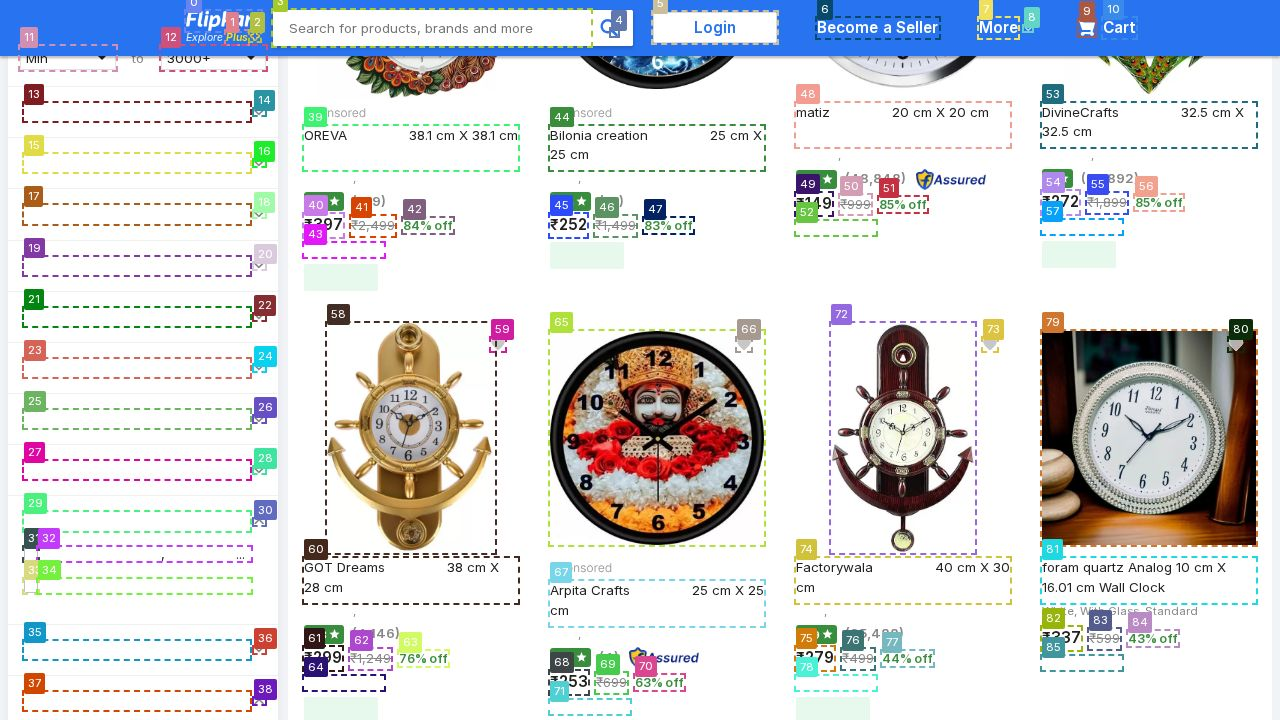

Final response: None


In [ ]:
res = await call_agent("कृपया मोबाइल फ़ोन ढूंढें और सस्ते फ़ोन दिखाएं।", page)

print(f"Final response: {res}")

1. retry: Could not parse LLM Output: Action: Click 81

This action will take the user to the product page for the "foram quartz Analog 10 cm X 16.01 cm Wall Clock," which is priced at ₹337, a 43% discount from its original price of ₹599. This product also offers free delivery, making it a suitable option for the user's request of good headphones under 5000 rupees.
2. Click: ['85']
3. retry: Could not parse LLM Output: Action: Click 81
Action: Scroll WINDOW; down
Action: Click 74
Action: Scroll WINDOW; down
Action: Click 67
Action: Scroll WINDOW; down
Action: Click 60
Action: Scroll WINDOW; down
Action: Click 53
Action: Scroll WINDOW; down
Action: Click 48
Action: Scroll WINDOW; down
Action: Click 43
Action: Scroll WINDOW; down
Action: Click 39
Action: Scroll WINDOW; down
Action: Click 34

These actions will navigate to the product pages of various headphones that are priced under 5000 rupees, as per the user's request. The selected products are based on the available information and t

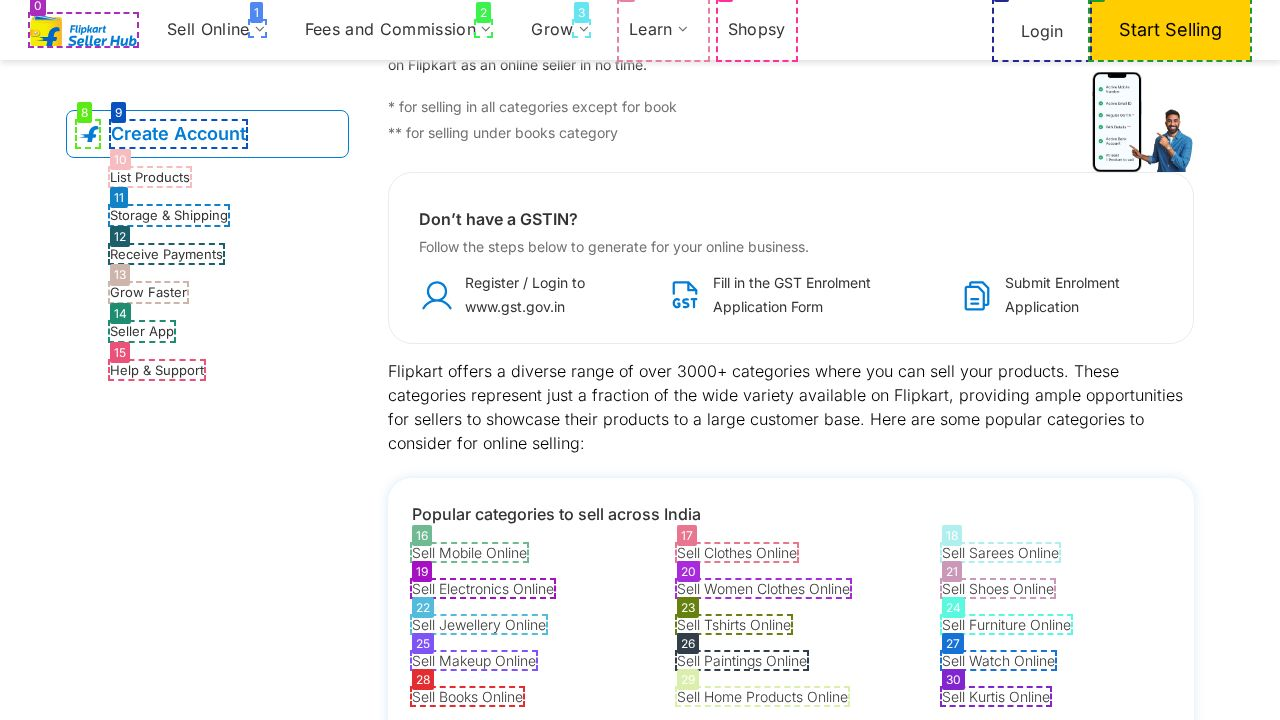

Final response: None


In [ ]:
res = await call_agent("5000 रुपये के अंदर अच्छे हेडफ़ोन दिखाओ।", page)
print(f"Final response: {res}")

1. retry: Could not parse LLM Output: Action: Type 16; सैमसंग मोबाइल के ऑफर्स

This action will search for offers related to Samsung mobiles on the Flipkart Seller Hub page.
2. Click: ['16']
3. retry: Could not parse LLM Output: Action: Type 5; सैमसंग मोबाइल ऑफर्स

Explanation: The user is asking for offers on Samsung mobiles. The search bar is located at UI element 5, so we type the query there.
4. retry: Could not parse LLM Output: Action: Type 5; सैमसंग मोबाइल ऑफर्स

Explanation: The user is asking for offers on Samsung mobiles. The search bar is located at UI element 5. By typing "सैमसंग मोबाइल ऑफर्स" into the search bar, the website should display relevant offers and deals for Samsung mobiles.
5. retry: Could not parse LLM Output: Action: Type 5; सैमसंग मोबाइल ऑफर्स

This action will search for offers related to Samsung mobiles on the Flipkart Seller Hub page.
6. retry: Could not parse LLM Output: Action: Type 5; सैमसंग मोबाइल ऑफर्स

The user is likely looking for special deals or

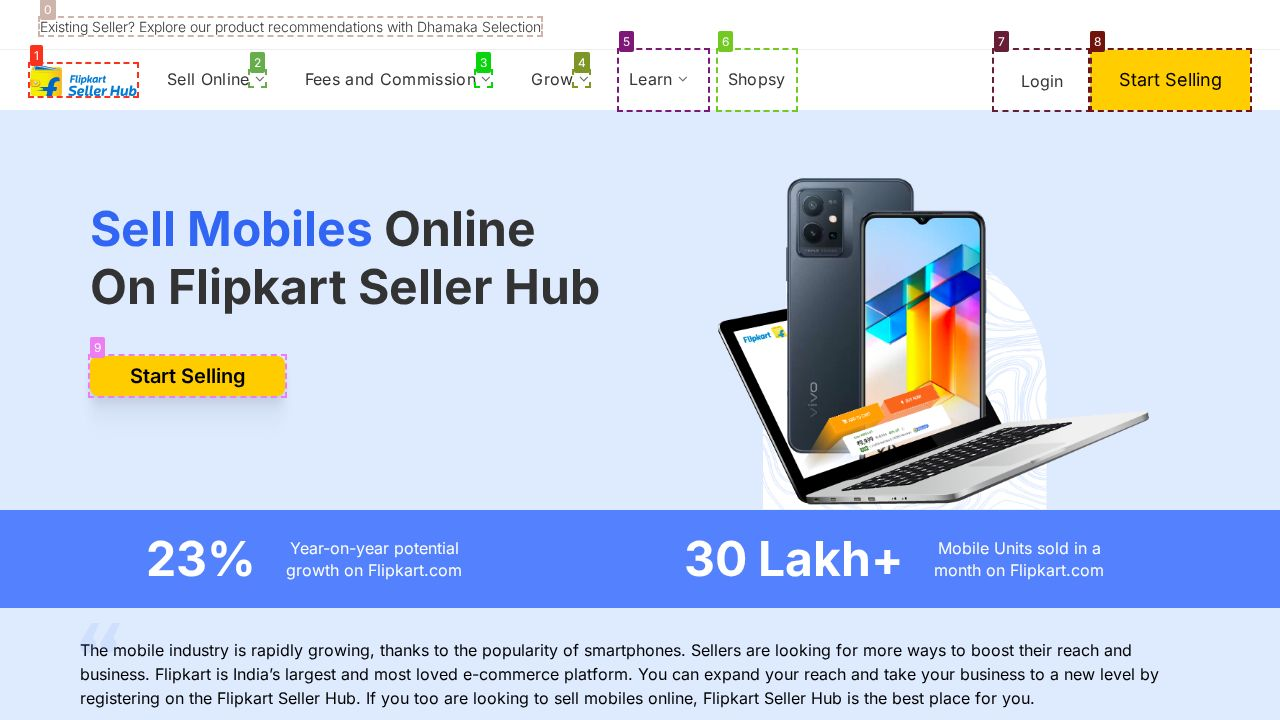

GraphRecursionError: Recursion limit of 150 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [ ]:
res = await call_agent("सैमसंग मोबाइल के ऑफर्स दिखाओ।", page)
print(f"Final response: {res}")